In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(317441, 828)
(317441, 1)
validation
(36648, 828)
(36648, 1)
test
(43097, 828)
(43097, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 37s - loss: 0.2820 - STD: 2.4360e-04 - MAE: 0.5223

 4/32 [==>...........................] - ETA: 0s - loss: 0.0988 - STD: 6.0246e-04 - MAE: 0.2467 

 5/32 [===>..........................] - ETA: 0s - loss: 0.0822 - STD: 5.2922e-04 - MAE: 0.2158

 6/32 [====>.........................] - ETA: 1s - loss: 0.0720 - STD: 4.6260e-04 - MAE: 0.1982

 7/32 [=====>........................] - ETA: 1s - loss: 0.0652 - STD: 4.0726e-04 - MAE: 0.1876

 8/32 [======>.......................] - ETA: 1s - loss: 0.0603 - STD: 3.6212e-04 - MAE: 0.1806

 9/32 [=======>......................] - ETA: 1s - loss: 0.0567 - STD: 3.2518e-04 - MAE: 0.1758

10/32 [========>.....................] - ETA: 1s - loss: 0.0540 - STD: 2.9458e-04 - MAE: 0.1723

11/32 [=========>....................] - ETA: 1s - loss: 0.0518 - STD: 2.6890e-04 - MAE: 0.1697

12/32 [==========>...................] - ETA: 1s - loss: 0.0500 - STD: 2.4709e-04 - MAE: 0.1677

13/32 [===========>..................] - ETA: 0s - loss: 0.0485 - STD: 2.2843e-04 - MAE: 0.1657

14/32 [============>.................] - ETA: 0s - loss: 0.0471 - STD: 2.1233e-04 - MAE: 0.1640

15/32 [=============>................] - ETA: 1s - loss: 0.0463 - STD: 1.9847e-04 - MAE: 0.1626

19/32 [================>.............] - ETA: 1s - loss: 0.0425 - STD: 1.5855e-04 - MAE: 0.1575

20/32 [=================>............] - ETA: 0s - loss: 0.0416 - STD: 1.5127e-04 - MAE: 0.1561

21/32 [==================>...........] - ETA: 0s - loss: 0.0408 - STD: 1.4472e-04 - MAE: 0.1547

22/32 [===================>..........] - ETA: 0s - loss: 0.0400 - STD: 1.3888e-04 - MAE: 0.1532

23/32 [====================>.........] - ETA: 0s - loss: 0.0392 - STD: 1.3360e-04 - MAE: 0.1516

24/32 [=====================>........] - ETA: 0s - loss: 0.0385 - STD: 1.2881e-04 - MAE: 0.1499

25/32 [======================>.......] - ETA: 0s - loss: 0.0377 - STD: 1.2443e-04 - MAE: 0.1481

26/32 [=======================>......] - ETA: 0s - loss: 0.0369 - STD: 1.2041e-04 - MAE: 0.1461

27/32 [========================>.....] - ETA: 0s - loss: 0.0361 - STD: 1.1669e-04 - MAE: 0.1440

28/32 [=========================>....] - ETA: 0s - loss: 0.0353 - STD: 1.1333e-04 - MAE: 0.1419

29/32 [==========================>...] - ETA: 0s - loss: 0.0345 - STD: 1.1021e-04 - MAE: 0.1399

30/32 [===========================>..] - ETA: 0s - loss: 0.0337 - STD: 1.0730e-04 - MAE: 0.1378

31/32 [============================>.] - ETA: 0s - loss: 0.0329 - STD: 1.0461e-04 - MAE: 0.1357

32/32 [==============================] - ETA: 0s - loss: 0.0322 - STD: 1.0209e-04 - MAE: 0.1339

32/32 [==============================] - 4s 91ms/step - loss: 0.0322 - STD: 1.0209e-04 - MAE: 0.1339 - val_loss: 0.0096 - val_STD: 2.0609e-05 - val_MAE: 0.0784


Epoch 2/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0094 - STD: 2.6332e-05 - MAE: 0.0771

 2/32 [>.............................] - ETA: 1s - loss: 0.0097 - STD: 2.6300e-05 - MAE: 0.0794

 3/32 [=>............................] - ETA: 1s - loss: 0.0100 - STD: 2.5638e-05 - MAE: 0.0816

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 2.5658e-05 - MAE: 0.0834

 5/32 [===>..........................] - ETA: 1s - loss: 0.0106 - STD: 2.5604e-05 - MAE: 0.0853

 6/32 [====>.........................] - ETA: 1s - loss: 0.0109 - STD: 2.4844e-05 - MAE: 0.0866

 7/32 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 2.3869e-05 - MAE: 0.0876

 8/32 [======>.......................] - ETA: 1s - loss: 0.0111 - STD: 2.3463e-05 - MAE: 0.0881

 9/32 [=======>......................] - ETA: 1s - loss: 0.0111 - STD: 2.3087e-05 - MAE: 0.0882

10/32 [========>.....................] - ETA: 1s - loss: 0.0111 - STD: 2.2456e-05 - MAE: 0.0880

11/32 [=========>....................] - ETA: 1s - loss: 0.0110 - STD: 2.2049e-05 - MAE: 0.0875

12/32 [==========>...................] - ETA: 1s - loss: 0.0109 - STD: 2.1411e-05 - MAE: 0.0868

13/32 [===========>..................] - ETA: 1s - loss: 0.0108 - STD: 2.0802e-05 - MAE: 0.0861

14/32 [============>.................] - ETA: 1s - loss: 0.0107 - STD: 2.0136e-05 - MAE: 0.0853

15/32 [=============>................] - ETA: 0s - loss: 0.0106 - STD: 1.9557e-05 - MAE: 0.0847

16/32 [==============>...............] - ETA: 0s - loss: 0.0106 - STD: 1.8907e-05 - MAE: 0.0840

17/32 [==============>...............] - ETA: 0s - loss: 0.0105 - STD: 1.8328e-05 - MAE: 0.0835

18/32 [===============>..............] - ETA: 0s - loss: 0.0105 - STD: 1.7740e-05 - MAE: 0.0831

20/32 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 1.6821e-05 - MAE: 0.0821

21/32 [==================>...........] - ETA: 0s - loss: 0.0104 - STD: 1.6474e-05 - MAE: 0.0818

22/32 [===================>..........] - ETA: 0s - loss: 0.0104 - STD: 1.6175e-05 - MAE: 0.0815

23/32 [====================>.........] - ETA: 0s - loss: 0.0104 - STD: 1.5820e-05 - MAE: 0.0812

24/32 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 1.5509e-05 - MAE: 0.0809

25/32 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 1.5269e-05 - MAE: 0.0807

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 1.4988e-05 - MAE: 0.0805

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 1.4777e-05 - MAE: 0.0803

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 1.4540e-05 - MAE: 0.0801

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 1.4402e-05 - MAE: 0.0800

30/32 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 1.4167e-05 - MAE: 0.0799

31/32 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 1.3988e-05 - MAE: 0.0799

32/32 [==============================] - ETA: 0s - loss: 0.0102 - STD: 1.3785e-05 - MAE: 0.0798

32/32 [==============================] - 2s 61ms/step - loss: 0.0102 - STD: 1.3785e-05 - MAE: 0.0798 - val_loss: 0.0097 - val_STD: 8.4960e-06 - val_MAE: 0.0794


Epoch 3/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0097 - STD: 1.2425e-05 - MAE: 0.0789

 2/32 [>.............................] - ETA: 1s - loss: 0.0097 - STD: 1.1104e-05 - MAE: 0.0789

 3/32 [=>............................] - ETA: 1s - loss: 0.0097 - STD: 1.1031e-05 - MAE: 0.0789

 4/32 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 1.0223e-05 - MAE: 0.0787

 5/32 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 1.0016e-05 - MAE: 0.0788

 6/32 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 9.9609e-06 - MAE: 0.0787

 7/32 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 9.9029e-06 - MAE: 0.0785

 8/32 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 9.7481e-06 - MAE: 0.0783

 9/32 [=======>......................] - ETA: 1s - loss: 0.0096 - STD: 9.7323e-06 - MAE: 0.0781

10/32 [========>.....................] - ETA: 1s - loss: 0.0096 - STD: 9.7154e-06 - MAE: 0.0780

11/32 [=========>....................] - ETA: 1s - loss: 0.0096 - STD: 9.4043e-06 - MAE: 0.0779

12/32 [==========>...................] - ETA: 1s - loss: 0.0096 - STD: 9.3609e-06 - MAE: 0.0777

13/32 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 9.2221e-06 - MAE: 0.0776

14/32 [============>.................] - ETA: 1s - loss: 0.0096 - STD: 9.1461e-06 - MAE: 0.0774

15/32 [=============>................] - ETA: 1s - loss: 0.0096 - STD: 9.1639e-06 - MAE: 0.0772

16/32 [==============>...............] - ETA: 0s - loss: 0.0096 - STD: 9.1577e-06 - MAE: 0.0772

17/32 [==============>...............] - ETA: 0s - loss: 0.0096 - STD: 9.2320e-06 - MAE: 0.0771

18/32 [===============>..............] - ETA: 0s - loss: 0.0096 - STD: 9.2449e-06 - MAE: 0.0770

19/32 [================>.............] - ETA: 0s - loss: 0.0096 - STD: 9.1475e-06 - MAE: 0.0769

21/32 [==================>...........] - ETA: 0s - loss: 0.0096 - STD: 8.9964e-06 - MAE: 0.0769

22/32 [===================>..........] - ETA: 0s - loss: 0.0096 - STD: 8.9490e-06 - MAE: 0.0768

23/32 [====================>.........] - ETA: 0s - loss: 0.0096 - STD: 8.8470e-06 - MAE: 0.0768

24/32 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 8.7853e-06 - MAE: 0.0768

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 8.7924e-06 - MAE: 0.0768

26/32 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 8.8353e-06 - MAE: 0.0768

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 8.8521e-06 - MAE: 0.0768

28/32 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 8.8660e-06 - MAE: 0.0768

29/32 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 8.8787e-06 - MAE: 0.0768

30/32 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 8.8923e-06 - MAE: 0.0768

31/32 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 8.8981e-06 - MAE: 0.0768

32/32 [==============================] - ETA: 0s - loss: 0.0096 - STD: 8.8727e-06 - MAE: 0.0768

32/32 [==============================] - 2s 63ms/step - loss: 0.0096 - STD: 8.8727e-06 - MAE: 0.0768 - val_loss: 0.0096 - val_STD: 5.0313e-06 - val_MAE: 0.0775


Epoch 4/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0093 - STD: 7.0995e-06 - MAE: 0.0754

 2/32 [>.............................] - ETA: 1s - loss: 0.0093 - STD: 8.2266e-06 - MAE: 0.0758

 3/32 [=>............................] - ETA: 1s - loss: 0.0094 - STD: 8.5269e-06 - MAE: 0.0763

 4/32 [==>...........................] - ETA: 1s - loss: 0.0094 - STD: 8.2125e-06 - MAE: 0.0762

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 8.0436e-06 - MAE: 0.0761

 6/32 [====>.........................] - ETA: 1s - loss: 0.0094 - STD: 7.9215e-06 - MAE: 0.0762

 7/32 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 7.7540e-06 - MAE: 0.0761

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 7.6857e-06 - MAE: 0.0761

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 7.6077e-06 - MAE: 0.0761

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 7.4084e-06 - MAE: 0.0761

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 7.3952e-06 - MAE: 0.0762

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 7.4760e-06 - MAE: 0.0761

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 7.4824e-06 - MAE: 0.0762

15/32 [=============>................] - ETA: 0s - loss: 0.0095 - STD: 7.6142e-06 - MAE: 0.0762

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 7.7797e-06 - MAE: 0.0763

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 7.9233e-06 - MAE: 0.0763

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 7.9987e-06 - MAE: 0.0762

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 8.0953e-06 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 8.1673e-06 - MAE: 0.0763

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 8.2201e-06 - MAE: 0.0763

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 8.2748e-06 - MAE: 0.0764

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 8.3267e-06 - MAE: 0.0764

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 8.3877e-06 - MAE: 0.0764

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 8.4592e-06 - MAE: 0.0764

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 8.5371e-06 - MAE: 0.0764

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 8.5875e-06 - MAE: 0.0764

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 8.6257e-06 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 8.6402e-06 - MAE: 0.0764

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 8.6343e-06 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 8.6812e-06 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 8.7271e-06 - MAE: 0.0764

32/32 [==============================] - 2s 62ms/step - loss: 0.0095 - STD: 8.7271e-06 - MAE: 0.0764 - val_loss: 0.0096 - val_STD: 5.2778e-06 - val_MAE: 0.0771


Epoch 5/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0094 - STD: 9.7150e-06 - MAE: 0.0757

 2/32 [>.............................] - ETA: 1s - loss: 0.0094 - STD: 1.0042e-05 - MAE: 0.0760

 3/32 [=>............................] - ETA: 1s - loss: 0.0094 - STD: 1.0148e-05 - MAE: 0.0757

 4/32 [==>...........................] - ETA: 1s - loss: 0.0094 - STD: 1.0116e-05 - MAE: 0.0760

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 1.0003e-05 - MAE: 0.0759

 6/32 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 9.8512e-06 - MAE: 0.0761

 7/32 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 9.8160e-06 - MAE: 0.0761

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 9.7774e-06 - MAE: 0.0764

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 9.6810e-06 - MAE: 0.0764

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 9.5777e-06 - MAE: 0.0764

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 9.4887e-06 - MAE: 0.0764

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 9.4373e-06 - MAE: 0.0764

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 9.4294e-06 - MAE: 0.0765

15/32 [=============>................] - ETA: 0s - loss: 0.0095 - STD: 9.4398e-06 - MAE: 0.0764

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 9.4498e-06 - MAE: 0.0764

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 9.5126e-06 - MAE: 0.0764

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 9.5607e-06 - MAE: 0.0764

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 9.5544e-06 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 9.5563e-06 - MAE: 0.0763

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 9.5943e-06 - MAE: 0.0763

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 9.7032e-06 - MAE: 0.0763

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 9.7966e-06 - MAE: 0.0763

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 9.8876e-06 - MAE: 0.0763

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 9.9651e-06 - MAE: 0.0763

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 9.9807e-06 - MAE: 0.0763

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 9.9830e-06 - MAE: 0.0763

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 1.0029e-05 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 1.0024e-05 - MAE: 0.0763

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 9.9796e-06 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 9.9900e-06 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 1.0013e-05 - MAE: 0.0764

32/32 [==============================] - 2s 62ms/step - loss: 0.0095 - STD: 1.0013e-05 - MAE: 0.0764 - val_loss: 0.0096 - val_STD: 8.8436e-06 - val_MAE: 0.0776


Epoch 6/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0096 - STD: 1.0076e-05 - MAE: 0.0771

 2/32 [>.............................] - ETA: 1s - loss: 0.0096 - STD: 1.0204e-05 - MAE: 0.0771

 3/32 [=>............................] - ETA: 1s - loss: 0.0096 - STD: 1.0443e-05 - MAE: 0.0770

 4/32 [==>...........................] - ETA: 1s - loss: 0.0095 - STD: 1.0627e-05 - MAE: 0.0767

 5/32 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 1.0478e-05 - MAE: 0.0770

 6/32 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 1.0442e-05 - MAE: 0.0770

 7/32 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 1.0396e-05 - MAE: 0.0770

 8/32 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 1.0435e-05 - MAE: 0.0769

 9/32 [=======>......................] - ETA: 1s - loss: 0.0096 - STD: 1.0447e-05 - MAE: 0.0767

10/32 [========>.....................] - ETA: 1s - loss: 0.0096 - STD: 1.0452e-05 - MAE: 0.0767

11/32 [=========>....................] - ETA: 1s - loss: 0.0096 - STD: 1.0561e-05 - MAE: 0.0768

12/32 [==========>...................] - ETA: 1s - loss: 0.0096 - STD: 1.0650e-05 - MAE: 0.0767

13/32 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 1.0709e-05 - MAE: 0.0767

14/32 [============>.................] - ETA: 1s - loss: 0.0096 - STD: 1.0744e-05 - MAE: 0.0768

16/32 [==============>...............] - ETA: 0s - loss: 0.0096 - STD: 1.0841e-05 - MAE: 0.0767

17/32 [==============>...............] - ETA: 0s - loss: 0.0096 - STD: 1.0967e-05 - MAE: 0.0767

18/32 [===============>..............] - ETA: 0s - loss: 0.0096 - STD: 1.1149e-05 - MAE: 0.0767

19/32 [================>.............] - ETA: 0s - loss: 0.0096 - STD: 1.1356e-05 - MAE: 0.0767

20/32 [=================>............] - ETA: 0s - loss: 0.0096 - STD: 1.1575e-05 - MAE: 0.0767

21/32 [==================>...........] - ETA: 0s - loss: 0.0096 - STD: 1.1796e-05 - MAE: 0.0767

22/32 [===================>..........] - ETA: 0s - loss: 0.0096 - STD: 1.2005e-05 - MAE: 0.0767

23/32 [====================>.........] - ETA: 0s - loss: 0.0096 - STD: 1.2201e-05 - MAE: 0.0766

24/32 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 1.2399e-05 - MAE: 0.0766

25/32 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 1.2616e-05 - MAE: 0.0766

26/32 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 1.2801e-05 - MAE: 0.0766

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 1.3015e-05 - MAE: 0.0766

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 1.3204e-05 - MAE: 0.0766

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 1.3385e-05 - MAE: 0.0765

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 1.3534e-05 - MAE: 0.0765

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 1.3677e-05 - MAE: 0.0765

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 1.3844e-05 - MAE: 0.0765

32/32 [==============================] - 2s 62ms/step - loss: 0.0095 - STD: 1.3844e-05 - MAE: 0.0765 - val_loss: 0.0095 - val_STD: 1.6516e-05 - val_MAE: 0.0772


Epoch 7/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0095 - STD: 1.9976e-05 - MAE: 0.0763

 2/32 [>.............................] - ETA: 1s - loss: 0.0095 - STD: 2.0047e-05 - MAE: 0.0764

 3/32 [=>............................] - ETA: 1s - loss: 0.0096 - STD: 2.0437e-05 - MAE: 0.0766

 4/32 [==>...........................] - ETA: 1s - loss: 0.0095 - STD: 2.0927e-05 - MAE: 0.0763

 5/32 [===>..........................] - ETA: 1s - loss: 0.0095 - STD: 2.1302e-05 - MAE: 0.0763

 6/32 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 2.1495e-05 - MAE: 0.0764

 7/32 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 2.1532e-05 - MAE: 0.0765

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 2.1543e-05 - MAE: 0.0766

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 2.1694e-05 - MAE: 0.0764

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 2.1865e-05 - MAE: 0.0763

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 2.1951e-05 - MAE: 0.0763

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 2.1958e-05 - MAE: 0.0763

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 2.1962e-05 - MAE: 0.0763

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 2.2042e-05 - MAE: 0.0764

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 2.2153e-05 - MAE: 0.0763

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 2.2238e-05 - MAE: 0.0763

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 2.2347e-05 - MAE: 0.0763

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 2.2514e-05 - MAE: 0.0763

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 2.2775e-05 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 2.2951e-05 - MAE: 0.0763

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 2.3139e-05 - MAE: 0.0762

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 2.3670e-05 - MAE: 0.0762

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 2.3945e-05 - MAE: 0.0762

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 2.4303e-05 - MAE: 0.0763

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 2.4689e-05 - MAE: 0.0763

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 2.5070e-05 - MAE: 0.0763

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 2.5449e-05 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 2.5900e-05 - MAE: 0.0764

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 2.6376e-05 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 2.6866e-05 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 2.7331e-05 - MAE: 0.0764

32/32 [==============================] - 2s 61ms/step - loss: 0.0095 - STD: 2.7331e-05 - MAE: 0.0764 - val_loss: 0.0096 - val_STD: 3.6149e-05 - val_MAE: 0.0775


Epoch 8/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0092 - STD: 4.0652e-05 - MAE: 0.0752

 2/32 [>.............................] - ETA: 1s - loss: 0.0093 - STD: 4.1054e-05 - MAE: 0.0755

 3/32 [=>............................] - ETA: 1s - loss: 0.0093 - STD: 4.1239e-05 - MAE: 0.0757

 4/32 [==>...........................] - ETA: 1s - loss: 0.0094 - STD: 4.1649e-05 - MAE: 0.0760

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 4.2279e-05 - MAE: 0.0761

 6/32 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 4.2855e-05 - MAE: 0.0761

 7/32 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 4.3481e-05 - MAE: 0.0762

 8/32 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 4.4128e-05 - MAE: 0.0761

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 4.4773e-05 - MAE: 0.0763

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 4.5860e-05 - MAE: 0.0764

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 4.6325e-05 - MAE: 0.0764

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 4.6823e-05 - MAE: 0.0764

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 4.7396e-05 - MAE: 0.0764

15/32 [=============>................] - ETA: 0s - loss: 0.0095 - STD: 4.8002e-05 - MAE: 0.0764

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 4.8602e-05 - MAE: 0.0764

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 4.9167e-05 - MAE: 0.0764

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 4.9841e-05 - MAE: 0.0764

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 5.0545e-05 - MAE: 0.0764

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 5.1281e-05 - MAE: 0.0764

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 5.2137e-05 - MAE: 0.0764

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 5.3037e-05 - MAE: 0.0764

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 5.3943e-05 - MAE: 0.0765

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 5.4827e-05 - MAE: 0.0764

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 5.5695e-05 - MAE: 0.0764

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 5.6529e-05 - MAE: 0.0764

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 5.7349e-05 - MAE: 0.0764

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 5.8166e-05 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 5.8969e-05 - MAE: 0.0764

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 5.9760e-05 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 6.0627e-05 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 6.1490e-05 - MAE: 0.0764

32/32 [==============================] - 2s 62ms/step - loss: 0.0095 - STD: 6.1490e-05 - MAE: 0.0764 - val_loss: 0.0095 - val_STD: 8.1485e-05 - val_MAE: 0.0773


Epoch 9/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0095 - STD: 8.9602e-05 - MAE: 0.0765

 2/32 [>.............................] - ETA: 2s - loss: 0.0096 - STD: 9.1311e-05 - MAE: 0.0768

 3/32 [=>............................] - ETA: 1s - loss: 0.0096 - STD: 9.2635e-05 - MAE: 0.0770

 4/32 [==>...........................] - ETA: 1s - loss: 0.0095 - STD: 9.3635e-05 - MAE: 0.0766

 5/32 [===>..........................] - ETA: 1s - loss: 0.0095 - STD: 9.5032e-05 - MAE: 0.0766

 6/32 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 9.6279e-05 - MAE: 0.0766

 7/32 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 9.7660e-05 - MAE: 0.0766

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 9.8891e-05 - MAE: 0.0766

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 1.0013e-04 - MAE: 0.0765

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 1.0152e-04 - MAE: 0.0765

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 1.0288e-04 - MAE: 0.0764

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 1.0434e-04 - MAE: 0.0765

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 1.0580e-04 - MAE: 0.0764

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 1.0720e-04 - MAE: 0.0764

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 1.0876e-04 - MAE: 0.0764

16/32 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 1.1037e-04 - MAE: 0.0764

17/32 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 1.1201e-04 - MAE: 0.0764

18/32 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 1.1370e-04 - MAE: 0.0764

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 1.1536e-04 - MAE: 0.0764

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 1.1714e-04 - MAE: 0.0764

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 1.2078e-04 - MAE: 0.0764

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 1.2268e-04 - MAE: 0.0765

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 1.2464e-04 - MAE: 0.0764

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 1.2668e-04 - MAE: 0.0764

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 1.2877e-04 - MAE: 0.0764

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 1.3090e-04 - MAE: 0.0764

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 1.3304e-04 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 1.3530e-04 - MAE: 0.0764

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 1.3746e-04 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 1.3975e-04 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 1.4213e-04 - MAE: 0.0764

32/32 [==============================] - 2s 71ms/step - loss: 0.0095 - STD: 1.4213e-04 - MAE: 0.0764 - val_loss: 0.0095 - val_STD: 1.9931e-04 - val_MAE: 0.0772


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0095 - STD: 2.2127e-04 - MAE: 0.0764

 2/32 [>.............................] - ETA: 1s - loss: 0.0095 - STD: 2.2359e-04 - MAE: 0.0763

 3/32 [=>............................] - ETA: 1s - loss: 0.0094 - STD: 2.2708e-04 - MAE: 0.0759

 4/32 [==>...........................] - ETA: 1s - loss: 0.0094 - STD: 2.3061e-04 - MAE: 0.0760

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 2.3372e-04 - MAE: 0.0759

 6/32 [====>.........................] - ETA: 1s - loss: 0.0094 - STD: 2.3754e-04 - MAE: 0.0759

 7/32 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 2.4165e-04 - MAE: 0.0759

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 2.4615e-04 - MAE: 0.0760

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 2.5016e-04 - MAE: 0.0760

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 2.5440e-04 - MAE: 0.0761

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 2.5857e-04 - MAE: 0.0761

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 2.6285e-04 - MAE: 0.0762

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 2.6725e-04 - MAE: 0.0762

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 2.7164e-04 - MAE: 0.0763

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 2.7625e-04 - MAE: 0.0762

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 2.8119e-04 - MAE: 0.0763

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 2.8626e-04 - MAE: 0.0763

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 2.9133e-04 - MAE: 0.0763

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 2.9673e-04 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 3.0225e-04 - MAE: 0.0763

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 3.0786e-04 - MAE: 0.0763

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 3.1377e-04 - MAE: 0.0763

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 3.1958e-04 - MAE: 0.0762

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 3.2571e-04 - MAE: 0.0762

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 3.3191e-04 - MAE: 0.0762

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 3.3845e-04 - MAE: 0.0763

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 3.4514e-04 - MAE: 0.0763

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 3.5210e-04 - MAE: 0.0763

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 3.5907e-04 - MAE: 0.0763

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 3.7400e-04 - MAE: 0.0763

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 3.8183e-04 - MAE: 0.0763

32/32 [==============================] - 2s 62ms/step - loss: 0.0095 - STD: 3.8183e-04 - MAE: 0.0763 - val_loss: 0.0095 - val_STD: 5.8482e-04 - val_MAE: 0.0774


Epoch 11/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0094 - STD: 6.4860e-04 - MAE: 0.0765

 2/32 [>.............................] - ETA: 1s - loss: 0.0094 - STD: 6.6448e-04 - MAE: 0.0765

 3/32 [=>............................] - ETA: 1s - loss: 0.0094 - STD: 6.7627e-04 - MAE: 0.0764

 4/32 [==>...........................] - ETA: 1s - loss: 0.0094 - STD: 6.9108e-04 - MAE: 0.0766

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 7.0413e-04 - MAE: 0.0765

 6/32 [====>.........................] - ETA: 1s - loss: 0.0094 - STD: 7.1809e-04 - MAE: 0.0764

 7/32 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 7.3145e-04 - MAE: 0.0763

 8/32 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 7.4434e-04 - MAE: 0.0761

 9/32 [=======>......................] - ETA: 1s - loss: 0.0094 - STD: 7.5871e-04 - MAE: 0.0761

10/32 [========>.....................] - ETA: 1s - loss: 0.0094 - STD: 7.7347e-04 - MAE: 0.0761

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 7.8929e-04 - MAE: 0.0763

12/32 [==========>...................] - ETA: 1s - loss: 0.0094 - STD: 8.0504e-04 - MAE: 0.0762

13/32 [===========>..................] - ETA: 1s - loss: 0.0094 - STD: 8.2096e-04 - MAE: 0.0762

14/32 [============>.................] - ETA: 1s - loss: 0.0094 - STD: 8.3782e-04 - MAE: 0.0761

15/32 [=============>................] - ETA: 1s - loss: 0.0094 - STD: 8.5584e-04 - MAE: 0.0761

16/32 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 8.7435e-04 - MAE: 0.0762

17/32 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 8.9295e-04 - MAE: 0.0761

18/32 [===============>..............] - ETA: 0s - loss: 0.0094 - STD: 9.1312e-04 - MAE: 0.0761

19/32 [================>.............] - ETA: 0s - loss: 0.0094 - STD: 9.3365e-04 - MAE: 0.0762

20/32 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 9.5429e-04 - MAE: 0.0762

21/32 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 9.7516e-04 - MAE: 0.0762

22/32 [===================>..........] - ETA: 0s - loss: 0.0094 - STD: 9.9683e-04 - MAE: 0.0762

23/32 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0010 - MAE: 0.0762    

24/32 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0010 - MAE: 0.0762

25/32 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0011 - MAE: 0.0762

26/32 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0011 - MAE: 0.0761

28/32 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0011 - MAE: 0.0761

29/32 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0012 - MAE: 0.0761

30/32 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0012 - MAE: 0.0761

31/32 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0012 - MAE: 0.0761

32/32 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0761

32/32 [==============================] - 2s 63ms/step - loss: 0.0094 - STD: 0.0013 - MAE: 0.0761 - val_loss: 0.0093 - val_STD: 0.0020 - val_MAE: 0.0766


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0752

 2/32 [>.............................] - ETA: 1s - loss: 0.0093 - STD: 0.0023 - MAE: 0.0758

 3/32 [=>............................] - ETA: 1s - loss: 0.0094 - STD: 0.0023 - MAE: 0.0761

 4/32 [==>...........................] - ETA: 1s - loss: 0.0093 - STD: 0.0024 - MAE: 0.0758

 5/32 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 0.0024 - MAE: 0.0758

 6/32 [====>.........................] - ETA: 1s - loss: 0.0094 - STD: 0.0025 - MAE: 0.0759

 7/32 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 0.0026 - MAE: 0.0759

 8/32 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 0.0026 - MAE: 0.0759

 9/32 [=======>......................] - ETA: 1s - loss: 0.0093 - STD: 0.0027 - MAE: 0.0758

10/32 [========>.....................] - ETA: 1s - loss: 0.0093 - STD: 0.0027 - MAE: 0.0757

11/32 [=========>....................] - ETA: 1s - loss: 0.0093 - STD: 0.0028 - MAE: 0.0758

12/32 [==========>...................] - ETA: 1s - loss: 0.0093 - STD: 0.0028 - MAE: 0.0756

13/32 [===========>..................] - ETA: 1s - loss: 0.0093 - STD: 0.0029 - MAE: 0.0757

14/32 [============>.................] - ETA: 1s - loss: 0.0093 - STD: 0.0030 - MAE: 0.0756

15/32 [=============>................] - ETA: 0s - loss: 0.0093 - STD: 0.0030 - MAE: 0.0756

16/32 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 0.0031 - MAE: 0.0756

17/32 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 0.0032 - MAE: 0.0755

18/32 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 0.0032 - MAE: 0.0755

19/32 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 0.0033 - MAE: 0.0754

20/32 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 0.0034 - MAE: 0.0754

21/32 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 0.0035 - MAE: 0.0754

22/32 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 0.0035 - MAE: 0.0754

23/32 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 0.0036 - MAE: 0.0753

24/32 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0037 - MAE: 0.0753

25/32 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0038 - MAE: 0.0753

26/32 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0039 - MAE: 0.0753

27/32 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0039 - MAE: 0.0753

29/32 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0041 - MAE: 0.0753

30/32 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0042 - MAE: 0.0753

31/32 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0043 - MAE: 0.0753

32/32 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0044 - MAE: 0.0753

32/32 [==============================] - 2s 63ms/step - loss: 0.0092 - STD: 0.0044 - MAE: 0.0753 - val_loss: 0.0089 - val_STD: 0.0072 - val_MAE: 0.0748


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0092 - STD: 0.0080 - MAE: 0.0760

 2/32 [>.............................] - ETA: 1s - loss: 0.0091 - STD: 0.0081 - MAE: 0.0751

 3/32 [=>............................] - ETA: 1s - loss: 0.0091 - STD: 0.0083 - MAE: 0.0748

 4/32 [==>...........................] - ETA: 1s - loss: 0.0090 - STD: 0.0084 - MAE: 0.0747

 5/32 [===>..........................] - ETA: 1s - loss: 0.0090 - STD: 0.0086 - MAE: 0.0746

 6/32 [====>.........................] - ETA: 1s - loss: 0.0089 - STD: 0.0088 - MAE: 0.0744

 7/32 [=====>........................] - ETA: 1s - loss: 0.0089 - STD: 0.0089 - MAE: 0.0744

 8/32 [======>.......................] - ETA: 1s - loss: 0.0090 - STD: 0.0091 - MAE: 0.0745

 9/32 [=======>......................] - ETA: 1s - loss: 0.0089 - STD: 0.0093 - MAE: 0.0744

10/32 [========>.....................] - ETA: 1s - loss: 0.0089 - STD: 0.0094 - MAE: 0.0742

11/32 [=========>....................] - ETA: 1s - loss: 0.0089 - STD: 0.0096 - MAE: 0.0741

12/32 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.0098 - MAE: 0.0740

13/32 [===========>..................] - ETA: 1s - loss: 0.0088 - STD: 0.0100 - MAE: 0.0740

14/32 [============>.................] - ETA: 1s - loss: 0.0088 - STD: 0.0102 - MAE: 0.0739

15/32 [=============>................] - ETA: 1s - loss: 0.0088 - STD: 0.0104 - MAE: 0.0738

16/32 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0106 - MAE: 0.0737

17/32 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0108 - MAE: 0.0737

18/32 [===============>..............] - ETA: 0s - loss: 0.0088 - STD: 0.0110 - MAE: 0.0736

19/32 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0112 - MAE: 0.0736

20/32 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0114 - MAE: 0.0736

21/32 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0116 - MAE: 0.0735

22/32 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 0.0118 - MAE: 0.0734

23/32 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.0121 - MAE: 0.0734

24/32 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0123 - MAE: 0.0733

25/32 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0125 - MAE: 0.0733

26/32 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0127 - MAE: 0.0732

27/32 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0130 - MAE: 0.0731

28/32 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0132 - MAE: 0.0731

29/32 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0134 - MAE: 0.0730

31/32 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0139 - MAE: 0.0729

32/32 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0141 - MAE: 0.0729

32/32 [==============================] - 2s 63ms/step - loss: 0.0086 - STD: 0.0141 - MAE: 0.0729 - val_loss: 0.0079 - val_STD: 0.0200 - val_MAE: 0.0709


Epoch 14/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0081 - STD: 0.0223 - MAE: 0.0717

 2/32 [>.............................] - ETA: 1s - loss: 0.0082 - STD: 0.0226 - MAE: 0.0715

 3/32 [=>............................] - ETA: 1s - loss: 0.0082 - STD: 0.0228 - MAE: 0.0712

 4/32 [==>...........................] - ETA: 1s - loss: 0.0081 - STD: 0.0230 - MAE: 0.0710

 5/32 [===>..........................] - ETA: 1s - loss: 0.0081 - STD: 0.0233 - MAE: 0.0708

 6/32 [====>.........................] - ETA: 1s - loss: 0.0081 - STD: 0.0235 - MAE: 0.0707

 7/32 [=====>........................] - ETA: 1s - loss: 0.0081 - STD: 0.0238 - MAE: 0.0707

 9/32 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0243 - MAE: 0.0707

10/32 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0246 - MAE: 0.0706

11/32 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0249 - MAE: 0.0705

12/32 [==========>...................] - ETA: 1s - loss: 0.0081 - STD: 0.0251 - MAE: 0.0705

13/32 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0254 - MAE: 0.0705

14/32 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0257 - MAE: 0.0704

15/32 [=============>................] - ETA: 0s - loss: 0.0080 - STD: 0.0259 - MAE: 0.0703

16/32 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0262 - MAE: 0.0703

17/32 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0264 - MAE: 0.0703

18/32 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.0266 - MAE: 0.0703

19/32 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.0268 - MAE: 0.0702

20/32 [=================>............] - ETA: 0s - loss: 0.0080 - STD: 0.0270 - MAE: 0.0701

21/32 [==================>...........] - ETA: 0s - loss: 0.0080 - STD: 0.0272 - MAE: 0.0701

22/32 [===================>..........] - ETA: 0s - loss: 0.0080 - STD: 0.0274 - MAE: 0.0700

23/32 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0276 - MAE: 0.0700

24/32 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0278 - MAE: 0.0699

25/32 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0280 - MAE: 0.0698

26/32 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0281 - MAE: 0.0698

27/32 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0283 - MAE: 0.0697

28/32 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0284 - MAE: 0.0696

29/32 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0286 - MAE: 0.0696

30/32 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0288 - MAE: 0.0695

31/32 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0289 - MAE: 0.0695

32/32 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0291 - MAE: 0.0694

32/32 [==============================] - 2s 62ms/step - loss: 0.0079 - STD: 0.0291 - MAE: 0.0694 - val_loss: 0.0072 - val_STD: 0.0305 - val_MAE: 0.0670


Epoch 15/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0343 - MAE: 0.0685

 3/32 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.0348 - MAE: 0.0679

 4/32 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.0350 - MAE: 0.0678

 5/32 [===>..........................] - ETA: 1s - loss: 0.0076 - STD: 0.0351 - MAE: 0.0677

 6/32 [====>.........................] - ETA: 1s - loss: 0.0076 - STD: 0.0351 - MAE: 0.0676

 7/32 [=====>........................] - ETA: 1s - loss: 0.0075 - STD: 0.0351 - MAE: 0.0675

 8/32 [======>.......................] - ETA: 1s - loss: 0.0075 - STD: 0.0352 - MAE: 0.0674

 9/32 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0354 - MAE: 0.0674

10/32 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.0355 - MAE: 0.0673

11/32 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0356 - MAE: 0.0672

12/32 [==========>...................] - ETA: 1s - loss: 0.0075 - STD: 0.0357 - MAE: 0.0673

13/32 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.0358 - MAE: 0.0673

14/32 [============>.................] - ETA: 1s - loss: 0.0075 - STD: 0.0359 - MAE: 0.0673

15/32 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.0360 - MAE: 0.0673

16/32 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0361 - MAE: 0.0672

17/32 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0362 - MAE: 0.0672

18/32 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0363 - MAE: 0.0672

19/32 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0363 - MAE: 0.0672

20/32 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.0364 - MAE: 0.0671

21/32 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.0365 - MAE: 0.0671

22/32 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0366 - MAE: 0.0670

23/32 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0367 - MAE: 0.0669

24/32 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0368 - MAE: 0.0669

25/32 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0369 - MAE: 0.0668

26/32 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0370 - MAE: 0.0667

27/32 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0371 - MAE: 0.0667

28/32 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0371 - MAE: 0.0666

29/32 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0372 - MAE: 0.0665

30/32 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0373 - MAE: 0.0664

31/32 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0374 - MAE: 0.0663

32/32 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0374 - MAE: 0.0662

32/32 [==============================] - 2s 63ms/step - loss: 0.0073 - STD: 0.0374 - MAE: 0.0662 - val_loss: 0.0066 - val_STD: 0.0343 - val_MAE: 0.0630


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0070 - STD: 0.0404 - MAE: 0.0639

 2/32 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0409 - MAE: 0.0631

 3/32 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.0410 - MAE: 0.0631

 4/32 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0413 - MAE: 0.0635

 5/32 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.0412 - MAE: 0.0632

 7/32 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.0416 - MAE: 0.0629

 8/32 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0415 - MAE: 0.0626

 9/32 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0419 - MAE: 0.0628

10/32 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0417 - MAE: 0.0625

11/32 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0421 - MAE: 0.0626

12/32 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0425 - MAE: 0.0624

13/32 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0424 - MAE: 0.0622

14/32 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0429 - MAE: 0.0622

15/32 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0433 - MAE: 0.0622

16/32 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0435 - MAE: 0.0620

17/32 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0438 - MAE: 0.0618

18/32 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0442 - MAE: 0.0618

19/32 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0616

20/32 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0447 - MAE: 0.0616

21/32 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0450 - MAE: 0.0616

22/32 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0451 - MAE: 0.0614

23/32 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0454 - MAE: 0.0614

24/32 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0456 - MAE: 0.0613

25/32 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0458 - MAE: 0.0611

26/32 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0460 - MAE: 0.0610

27/32 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0463 - MAE: 0.0610

28/32 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0464 - MAE: 0.0609

29/32 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0466 - MAE: 0.0608

30/32 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0470 - MAE: 0.0608

31/32 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0470 - MAE: 0.0607

32/32 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0473 - MAE: 0.0607

32/32 [==============================] - 2s 63ms/step - loss: 0.0063 - STD: 0.0473 - MAE: 0.0607 - val_loss: 0.0061 - val_STD: 0.0530 - val_MAE: 0.0637


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0584 - MAE: 0.0624

 2/32 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0596

 3/32 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0537 - MAE: 0.0585

 4/32 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0549 - MAE: 0.0591

 5/32 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0586

 6/32 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0540 - MAE: 0.0582

 7/32 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0545 - MAE: 0.0584

 8/32 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0544 - MAE: 0.0582

 9/32 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0541 - MAE: 0.0580

10/32 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0543 - MAE: 0.0579

11/32 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0545 - MAE: 0.0578

12/32 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0544 - MAE: 0.0577

13/32 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0544 - MAE: 0.0575

14/32 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0546 - MAE: 0.0575

15/32 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0545 - MAE: 0.0574

17/32 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0548 - MAE: 0.0573

18/32 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0549 - MAE: 0.0571

19/32 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0570

20/32 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0569

21/32 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0569

22/32 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0554 - MAE: 0.0568

23/32 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0556 - MAE: 0.0567

24/32 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0566

25/32 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0566

26/32 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0565

27/32 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0560 - MAE: 0.0565

28/32 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0562 - MAE: 0.0564

29/32 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0563 - MAE: 0.0564

30/32 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0563 - MAE: 0.0563

31/32 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0565 - MAE: 0.0562

32/32 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0565 - MAE: 0.0562

32/32 [==============================] - 2s 57ms/step - loss: 0.0056 - STD: 0.0565 - MAE: 0.0562 - val_loss: 0.0054 - val_STD: 0.0585 - val_MAE: 0.0584


Epoch 18/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0561

 2/32 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0550

 3/32 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0556

 4/32 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0549

 5/32 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0548

 6/32 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0602 - MAE: 0.0553

 7/32 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0553

 8/32 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0595 - MAE: 0.0554

 9/32 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0554

10/32 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0590 - MAE: 0.0552

11/32 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0552

12/32 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0551

13/32 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0591 - MAE: 0.0550

14/32 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0592 - MAE: 0.0550

15/32 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0550

16/32 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0590 - MAE: 0.0549

18/32 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0549

19/32 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0548

20/32 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0547

21/32 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0549

22/32 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0548

23/32 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0547

24/32 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0595 - MAE: 0.0548

25/32 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0547

26/32 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0546

27/32 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0548

28/32 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0546

29/32 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0545

30/32 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0598 - MAE: 0.0546

31/32 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0598 - MAE: 0.0545

32/32 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0544

32/32 [==============================] - 2s 63ms/step - loss: 0.0053 - STD: 0.0597 - MAE: 0.0544 - val_loss: 0.0050 - val_STD: 0.0609 - val_MAE: 0.0567


Epoch 19/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0549

 2/32 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0538

 3/32 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0617 - MAE: 0.0535

 4/32 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0625 - MAE: 0.0537

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0537

 6/32 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0533

 7/32 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0531

 8/32 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0532

 9/32 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0530

10/32 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0528

11/32 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0529

12/32 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0528

13/32 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0527

14/32 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0528

15/32 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0526

16/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0525

17/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0525

18/32 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0524

20/32 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0524

21/32 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0523

22/32 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0523

23/32 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0522

24/32 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0522

25/32 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0521

26/32 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0521

27/32 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0520

28/32 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0520

29/32 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0520

30/32 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0520

31/32 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0520

32/32 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0519

32/32 [==============================] - 2s 62ms/step - loss: 0.0048 - STD: 0.0637 - MAE: 0.0519 - val_loss: 0.0047 - val_STD: 0.0615 - val_MAE: 0.0525


Epoch 20/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0642 - MAE: 0.0507

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0513

 3/32 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0509

 4/32 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0513

 5/32 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0510

 6/32 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0509

 7/32 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0510

 8/32 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0509

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0511

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0509

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0509

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0508

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0508

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0509

15/32 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0508

16/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0508

17/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0509

18/32 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0508

19/32 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0509

20/32 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0508

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0507

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0507

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0507

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0507

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0506

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0507

28/32 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0506

29/32 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0506

30/32 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0506

31/32 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0506

32/32 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0506

32/32 [==============================] - 2s 62ms/step - loss: 0.0046 - STD: 0.0660 - MAE: 0.0506 - val_loss: 0.0051 - val_STD: 0.0713 - val_MAE: 0.0577


Epoch 21/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0555

 2/32 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0544

 3/32 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0535

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0527

 6/32 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0529

 7/32 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0524

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0520

 9/32 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0522

10/32 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0519

11/32 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0517

12/32 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0518

13/32 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0516

14/32 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0514

15/32 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0515

16/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0514

17/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0514

18/32 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0513

19/32 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0512

20/32 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0512

21/32 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0511

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0511

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0510

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0509

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0508

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0508

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0507

28/32 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0507

29/32 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0506

30/32 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0506

31/32 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0505

32/32 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0505

32/32 [==============================] - 2s 63ms/step - loss: 0.0046 - STD: 0.0669 - MAE: 0.0505 - val_loss: 0.0044 - val_STD: 0.0647 - val_MAE: 0.0502


Epoch 22/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0483

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0485

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0493

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0494

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0500

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0498

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0497

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0496

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0495

10/32 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0497

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0497

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0497

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0496

14/32 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0496

15/32 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0496

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0496

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0496

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0495

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0495

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0494

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0493

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0493

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0492

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0492

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0492

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0492

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0492

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

32/32 [==============================] - 2s 62ms/step - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491 - val_loss: 0.0046 - val_STD: 0.0608 - val_MAE: 0.0499


Epoch 23/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0624 - MAE: 0.0487

 2/32 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0518

 3/32 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0517

 4/32 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

 5/32 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0514

 6/32 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0510

 7/32 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0513

 8/32 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0509

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0506

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0507

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0506

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0504

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0506

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0506

16/32 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0504

17/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0503

18/32 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0503

19/32 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0503

20/32 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0502

21/32 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

22/32 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0501

23/32 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0500

24/32 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0499

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0498

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0498

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0497

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0497

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0497

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0496

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0496

32/32 [==============================] - 2s 63ms/step - loss: 0.0044 - STD: 0.0686 - MAE: 0.0496 - val_loss: 0.0043 - val_STD: 0.0641 - val_MAE: 0.0489


Epoch 24/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0668 - MAE: 0.0475

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0478

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0485

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0486

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0486

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0490

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0489

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0488

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0489

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0489

13/32 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0489

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0488

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0487

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0487

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0487

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0487

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0487

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0487

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0486

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0485

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0485

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0484

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0483

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0483

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0483

32/32 [==============================] - 2s 63ms/step - loss: 0.0042 - STD: 0.0703 - MAE: 0.0483 - val_loss: 0.0041 - val_STD: 0.0675 - val_MAE: 0.0485


Epoch 25/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0478

 2/32 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0483

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

 9/32 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

11/32 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

12/32 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

13/32 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0477

14/32 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

15/32 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0478

16/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

17/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

19/32 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0477

20/32 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0477

21/32 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0478

22/32 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

23/32 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

24/32 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

25/32 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

26/32 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0477

27/32 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0477

28/32 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0477

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0477

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

32/32 [==============================] - 2s 62ms/step - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479 - val_loss: 0.0043 - val_STD: 0.0623 - val_MAE: 0.0481


Epoch 26/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0472

 2/32 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0475

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0478

 4/32 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0482

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0496

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0498

 7/32 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0494

 8/32 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0702 - MAE: 0.0501

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0505

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0502

11/32 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0516

12/32 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0518

13/32 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0519

14/32 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0526

15/32 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0527

16/32 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0526

17/32 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0525

18/32 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0527

19/32 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0527

20/32 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0526

21/32 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0524

22/32 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0524

23/32 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0524

25/32 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0521

26/32 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0521

27/32 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0520

28/32 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0656 - MAE: 0.0518

29/32 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0656 - MAE: 0.0517

30/32 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0660 - MAE: 0.0517

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0661 - MAE: 0.0515

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0514

32/32 [==============================] - 2s 60ms/step - loss: 0.0047 - STD: 0.0660 - MAE: 0.0514 - val_loss: 0.0041 - val_STD: 0.0701 - val_MAE: 0.0492


Epoch 27/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0483

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0495

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0484

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0489

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0486

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0484

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0484

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0484

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0483

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0483

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0483

14/32 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0482

15/32 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0481

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0482

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0481

18/32 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

19/32 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

20/32 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

21/32 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

22/32 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

23/32 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480

24/32 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

25/32 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

26/32 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0478

27/32 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

28/32 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0478

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0478

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0477

32/32 [==============================] - 2s 62ms/step - loss: 0.0041 - STD: 0.0715 - MAE: 0.0477 - val_loss: 0.0040 - val_STD: 0.0710 - val_MAE: 0.0483


Epoch 28/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0463

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0466

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0468

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0469

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0470

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0470

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0470

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0471

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0470

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0470

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0469

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0470

32/32 [==============================] - 2s 61ms/step - loss: 0.0040 - STD: 0.0728 - MAE: 0.0470 - val_loss: 0.0041 - val_STD: 0.0643 - val_MAE: 0.0472


Epoch 29/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0664 - MAE: 0.0467

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0462

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0473

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0473

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0472

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0476

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0475

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0473

 9/32 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0477

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0476

11/32 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0475

12/32 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0477

13/32 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0476

14/32 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0475

15/32 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0477

17/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0475

18/32 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476

19/32 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476

20/32 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0475

21/32 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0475

22/32 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0474

23/32 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0474

24/32 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0474

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

32/32 [==============================] - 2s 61ms/step - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472 - val_loss: 0.0043 - val_STD: 0.0754 - val_MAE: 0.0511


Epoch 30/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0507

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0488

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0481

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0477

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0476

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0474

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0473

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0472

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0470

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0471

15/32 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0470

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0469

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0468

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0468

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0468

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0467

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0467

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0467

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0466

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466

32/32 [==============================] - 2s 69ms/step - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466 - val_loss: 0.0039 - val_STD: 0.0731 - val_MAE: 0.0472


Epoch 31/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0465

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0462

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0461

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0461

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0461

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0462

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0463

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0463

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0463

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0463

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0463

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0463

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0463

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0462

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0463

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0463

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0462

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0463

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0463

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0463

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0464

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0464

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0464

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0464

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0463

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0464

32/32 [==============================] - 2s 64ms/step - loss: 0.0039 - STD: 0.0737 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0696 - val_MAE: 0.0457


Epoch 32/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0454

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0456

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0465

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0461

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0463

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0464

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0463

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0462

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0461

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0462

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0461

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0460

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0461

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0461

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0461

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0460

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0460

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0460

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

32/32 [==============================] - 2s 68ms/step - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459 - val_loss: 0.0037 - val_STD: 0.0695 - val_MAE: 0.0452


Epoch 33/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0452

 2/32 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0449

 3/32 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0451

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0451

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0452

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0451

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0454

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0454

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0454

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0454

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0454

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0455

16/32 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

17/32 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0455

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0456

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0456

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0458

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458

32/32 [==============================] - 2s 67ms/step - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458 - val_loss: 0.0037 - val_STD: 0.0734 - val_MAE: 0.0467


Epoch 34/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0472

 2/32 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0466

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0466

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0462

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0460

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0462

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0462

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0462

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0461

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0460

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0461

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0460

16/32 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0459

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0459

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0458

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0458

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0457

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0457

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0457

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0457

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0456

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0457

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0456

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0456

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0456

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0456

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0455

32/32 [==============================] - 2s 71ms/step - loss: 0.0037 - STD: 0.0745 - MAE: 0.0455 - val_loss: 0.0036 - val_STD: 0.0745 - val_MAE: 0.0455


Epoch 35/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0460

 2/32 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0454

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0451

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0453

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0451

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0452

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0453

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

16/32 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0453

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

32/32 [==============================] - 2s 69ms/step - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0747 - val_MAE: 0.0459


Epoch 36/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0461

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0453

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0450

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0450

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0450

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0449

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0449

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0448

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0447

16/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0447

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0447

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0448

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0448

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0448

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0448

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0453

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0454

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0454

32/32 [==============================] - 2s 69ms/step - loss: 0.0037 - STD: 0.0749 - MAE: 0.0454 - val_loss: 0.0038 - val_STD: 0.0756 - val_MAE: 0.0476


Epoch 37/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0477

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0462

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0455

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0456

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0454

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0453

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0451

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0451

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0450

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0450

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0450

16/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

17/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0449

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0449

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0449

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0448

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0449

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0449

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0449

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0449

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0449

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0448

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0450

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

32/32 [==============================] - 2s 71ms/step - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0682 - val_MAE: 0.0435


Epoch 38/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0443

 2/32 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0462

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0459

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0457

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0460

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0463

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0462

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0462

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0459

16/32 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0457

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0457

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0455

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0455

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0454

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0454

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0453

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0453

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0452

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0451

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0451

32/32 [==============================] - 2s 69ms/step - loss: 0.0037 - STD: 0.0748 - MAE: 0.0451 - val_loss: 0.0035 - val_STD: 0.0751 - val_MAE: 0.0448


Epoch 39/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0450

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0447

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0445

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0445

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0445

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0443

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0445

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0443

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0443

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0443

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0443

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0442

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

32/32 [==============================] - 2s 70ms/step - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442 - val_loss: 0.0038 - val_STD: 0.0787 - val_MAE: 0.0472


Epoch 40/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0468

 2/32 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0453

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0449

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0448

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0447

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0446

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

16/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0445

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0445

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446

32/32 [==============================] - 2s 70ms/step - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446 - val_loss: 0.0033 - val_STD: 0.0725 - val_MAE: 0.0431


Epoch 41/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0434

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0443

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0445

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0442

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0442

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0442

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0446

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

16/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0443

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

32/32 [==============================] - 2s 70ms/step - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444 - val_loss: 0.0034 - val_STD: 0.0759 - val_MAE: 0.0445


Epoch 42/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0455

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0444

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0439

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0443

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0442

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0445

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0442

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0441

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0442

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0442

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0442

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0441

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0441

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0442

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0442

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0442

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0443

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0442

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0442

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0442

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0442

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0441

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0441

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0441

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0440

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0440

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0440

32/32 [==============================] - 2s 68ms/step - loss: 0.0035 - STD: 0.0763 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0769 - val_MAE: 0.0443


Epoch 43/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0444

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0434

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0435

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0435

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0435

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0434

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0436

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0437

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0437

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0436

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

17/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0436

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0437

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0437

20/32 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0436

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0437

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0437

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0438

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0438

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0438

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0437

32/32 [==============================] - 2s 71ms/step - loss: 0.0035 - STD: 0.0769 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0757 - val_MAE: 0.0439


Epoch 44/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0437

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0434

 3/32 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0431

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0431

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0431

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0434

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0435

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0438

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0437

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0436

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0437

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0438

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

17/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0438

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0440

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0441

20/32 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0442

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0441

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0442

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0441

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0441

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0442

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0442

30/32 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0441

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

32/32 [==============================] - 2s 71ms/step - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441 - val_loss: 0.0033 - val_STD: 0.0760 - val_MAE: 0.0431


Epoch 45/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

 2/32 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0435

 3/32 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0434

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0438

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0436

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0436

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0434

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

17/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0432

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0434

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0434

32/32 [==============================] - 2s 70ms/step - loss: 0.0034 - STD: 0.0773 - MAE: 0.0434 - val_loss: 0.0035 - val_STD: 0.0680 - val_MAE: 0.0430


Epoch 46/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0443

 2/32 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 3/32 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0446

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0443

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0441

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0438

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0436

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0435

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0434

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0436

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0436

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0435

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0435

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0434

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0433

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0433

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0786 - val_MAE: 0.0449


Epoch 47/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0815 - MAE: 0.0454

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0440

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0436

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0435

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0433

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0435

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0434

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0435

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0434

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0435

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0435

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0435

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0435

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0435

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0435

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0435

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435

32/32 [==============================] - 2s 71ms/step - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0731 - val_MAE: 0.0421


Epoch 48/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 2/32 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0427

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0426

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0428

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0429

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0430

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0430

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0430

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0430

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0430

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0430

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0430

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

32/32 [==============================] - 2s 70ms/step - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0733 - val_MAE: 0.0419


Epoch 49/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

 2/32 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0422

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0423

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0425

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0425

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0427

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0430

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0431

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0431

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

32/32 [==============================] - 2s 70ms/step - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0758 - val_MAE: 0.0421


Epoch 50/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

 2/32 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0425

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0425

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0426

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0426

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0427

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0425

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0425

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0426

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0426

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0427

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0426

16/32 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0426

17/32 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0426

18/32 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0426

19/32 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

20/32 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0426

21/32 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

22/32 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0426

23/32 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

24/32 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0426

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0427

26/32 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0426

27/32 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0427

28/32 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

29/32 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0427

30/32 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0427

31/32 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0427

32/32 [==============================] - 2s 70ms/step - loss: 0.0033 - STD: 0.0780 - MAE: 0.0428 - val_loss: 0.0036 - val_STD: 0.0804 - val_MAE: 0.0459


Epoch 51/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0847 - MAE: 0.0465

 2/32 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0440

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0435

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0434

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0437

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0440

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0443

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0440

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0439

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0440

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0441

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0440

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0439

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0441

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0442

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0443

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0445

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0445

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0448

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0447

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

32/32 [==============================] - 2s 69ms/step - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485 - val_loss: 0.0051 - val_STD: 0.0532 - val_MAE: 0.0512


Epoch 52/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0560 - MAE: 0.0517

 2/32 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0537 - MAE: 0.0552

 3/32 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0517

 4/32 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0661 - MAE: 0.0556

 5/32 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0537

 6/32 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0535

 7/32 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0528

 8/32 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0525

 9/32 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0533

10/32 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0527

12/32 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0519

13/32 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0516

14/32 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0516

15/32 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0512

16/32 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0509

17/32 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0507

18/32 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0505

19/32 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0506

20/32 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0503

21/32 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0649 - MAE: 0.0501

22/32 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0498

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0497

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0496

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0494

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0492

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0490

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0489

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0488

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0486

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0485

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0484

32/32 [==============================] - 2s 70ms/step - loss: 0.0042 - STD: 0.0676 - MAE: 0.0484 - val_loss: 0.0036 - val_STD: 0.0740 - val_MAE: 0.0462


Epoch 53/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0461

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0451

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0446

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0442

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0440

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432 - val_loss: 0.0033 - val_STD: 0.0751 - val_MAE: 0.0430


Epoch 54/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0431

 2/32 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

 3/32 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0427

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0427

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0428

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0427

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0427

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0428

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0427

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0427

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0426

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

16/32 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

17/32 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0425

18/32 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0425

19/32 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0425

21/32 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0425

22/32 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0425

23/32 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0424

24/32 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0424

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0424

26/32 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0424

27/32 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

28/32 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

29/32 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

30/32 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

31/32 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

32/32 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

32/32 [==============================] - 2s 69ms/step - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423 - val_loss: 0.0032 - val_STD: 0.0758 - val_MAE: 0.0422


Epoch 55/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0427

 2/32 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0422

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0421

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0421

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0421

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0420

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0421

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0422

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0422

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0422

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0422

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0421

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0422

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0422

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0422

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0786 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0728 - val_MAE: 0.0416


Epoch 56/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0420

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0420

 3/32 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0422

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

32/32 [==============================] - 2s 71ms/step - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420 - val_loss: 0.0032 - val_STD: 0.0756 - val_MAE: 0.0419


Epoch 57/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0421

 3/32 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0419

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0420

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0421

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

32/32 [==============================] - 2s 68ms/step - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420 - val_loss: 0.0032 - val_STD: 0.0772 - val_MAE: 0.0421


Epoch 58/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0805 - MAE: 0.0424

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0421

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0419

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0419

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0418

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0419

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0419

32/32 [==============================] - 2s 71ms/step - loss: 0.0032 - STD: 0.0790 - MAE: 0.0419 - val_loss: 0.0032 - val_STD: 0.0729 - val_MAE: 0.0415


Epoch 59/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0418

 2/32 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0425

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0422

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0420

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0800 - MAE: 0.0422

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0421

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0422

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0423

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0422

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0422

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0422

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0422

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0422

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421 - val_loss: 0.0032 - val_STD: 0.0767 - val_MAE: 0.0417


Epoch 60/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0420

 2/32 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0802 - MAE: 0.0417

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0421

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0419

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418 - val_loss: 0.0034 - val_STD: 0.0807 - val_MAE: 0.0437


Epoch 61/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0841 - MAE: 0.0430

 2/32 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0421

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0419

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0419

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0420

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0425

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0422

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0422

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0422

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420 - val_loss: 0.0032 - val_STD: 0.0780 - val_MAE: 0.0425


Epoch 62/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0821 - MAE: 0.0429

 2/32 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0422

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0423

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0421

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0423

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0426

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0423

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0426

12/32 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0426

13/32 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0426

14/32 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0426

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

16/32 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0426

17/32 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

18/32 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

19/32 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0425

20/32 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

21/32 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

22/32 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

23/32 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

26/32 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

27/32 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

28/32 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0423

29/32 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

30/32 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

31/32 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

32/32 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

32/32 [==============================] - 2s 69ms/step - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424 - val_loss: 0.0031 - val_STD: 0.0735 - val_MAE: 0.0413


Epoch 63/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 2/32 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0416

 3/32 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

 4/32 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0416

 5/32 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0415

 6/32 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0414

 7/32 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0413

 8/32 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0414

 9/32 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

10/32 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0415

11/32 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

12/32 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0415

13/32 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0415

14/32 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0418

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0418

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417 - val_loss: 0.0032 - val_STD: 0.0779 - val_MAE: 0.0420


Epoch 64/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0421

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0419

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0420

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0418

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0418

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

 9/32 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0422

10/32 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

11/32 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0421

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0420

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0419

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0419

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0418

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

32/32 [==============================] - 2s 69ms/step - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417 - val_loss: 0.0032 - val_STD: 0.0771 - val_MAE: 0.0420


Epoch 65/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0800 - MAE: 0.0416

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0419

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0797 - MAE: 0.0422

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0420

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0421

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0420

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0419

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0418

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0417

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

16/32 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0416

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

27/32 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0416

28/32 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

29/32 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

30/32 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

31/32 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

32/32 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

32/32 [==============================] - 2s 70ms/step - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415 - val_loss: 0.0032 - val_STD: 0.0716 - val_MAE: 0.0414


Epoch 66/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0754 - MAE: 0.0414

 2/32 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

 4/32 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 5/32 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0414

 6/32 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0414

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0421

15/32 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0421

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0421

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

19/32 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

20/32 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

21/32 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

22/32 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

23/32 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

24/32 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0423

26/32 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0423

27/32 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

28/32 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

29/32 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

30/32 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

31/32 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

32/32 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

32/32 [==============================] - 2s 69ms/step - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424 - val_loss: 0.0032 - val_STD: 0.0719 - val_MAE: 0.0417


Epoch 67/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0750 - MAE: 0.0410

 2/32 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 3/32 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0803 - MAE: 0.0414

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0414

 5/32 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0805 - MAE: 0.0417

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0416

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0416

 8/32 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0416

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0418

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

26/32 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

32/32 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0744 - val_MAE: 0.0412


Epoch 68/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 2/32 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0413

 3/32 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0414

 4/32 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0415

 5/32 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0415

 6/32 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0416

 7/32 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

 8/32 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0415

 9/32 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0415

10/32 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0415

11/32 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0414

12/32 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0414

13/32 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0414

14/32 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0416

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

17/32 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0416

18/32 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0416

19/32 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0416

20/32 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

22/32 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

23/32 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

24/32 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0415

25/32 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

26/32 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

27/32 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

28/32 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

29/32 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0414

30/32 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

31/32 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

32/32 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

32/32 [==============================] - 2s 69ms/step - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415 - val_loss: 0.0031 - val_STD: 0.0755 - val_MAE: 0.0414


Epoch 69/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0409

 2/32 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0411

 3/32 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0419

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

 7/32 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

 8/32 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0422

 9/32 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

11/32 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0419

12/32 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

13/32 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

14/32 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

15/32 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

16/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0419

17/32 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

18/32 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0420

19/32 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0420

20/32 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

21/32 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0419

22/32 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0419

23/32 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

24/32 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0418

25/32 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0418

27/32 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

28/32 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

29/32 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0416

32/32 [==============================] - 2s 71ms/step - loss: 0.0032 - STD: 0.0790 - MAE: 0.0416 - val_loss: 0.0032 - val_STD: 0.0782 - val_MAE: 0.0421


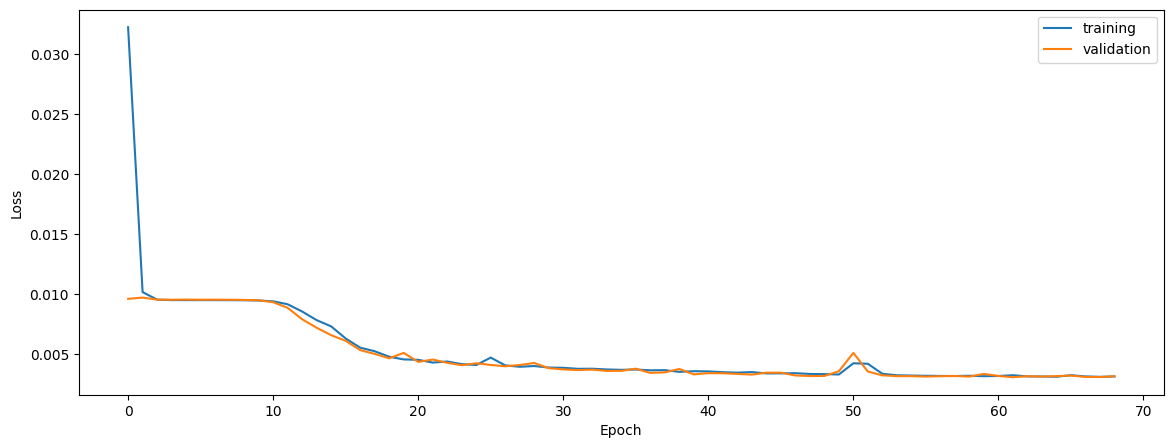

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8193918930237675
0.8222001553151616
0.7984769114597163


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8193918930237675
0.8222001553151616
0.7984769114597163


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8158018023272089
0.8203404321114665
0.7924096040385193


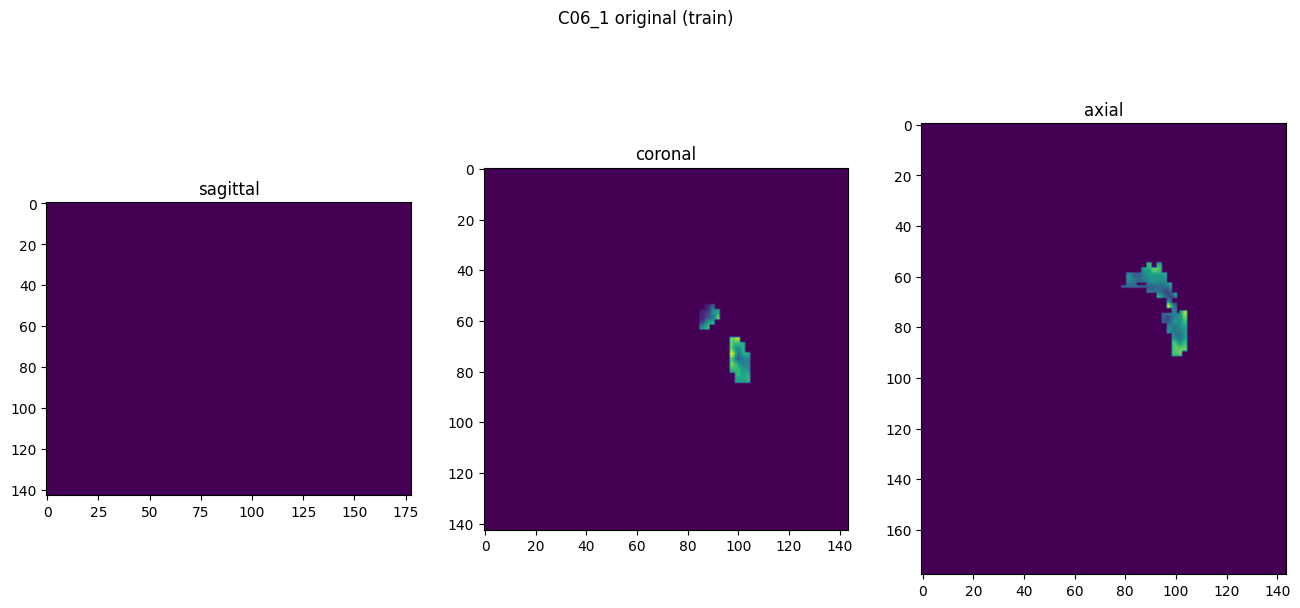

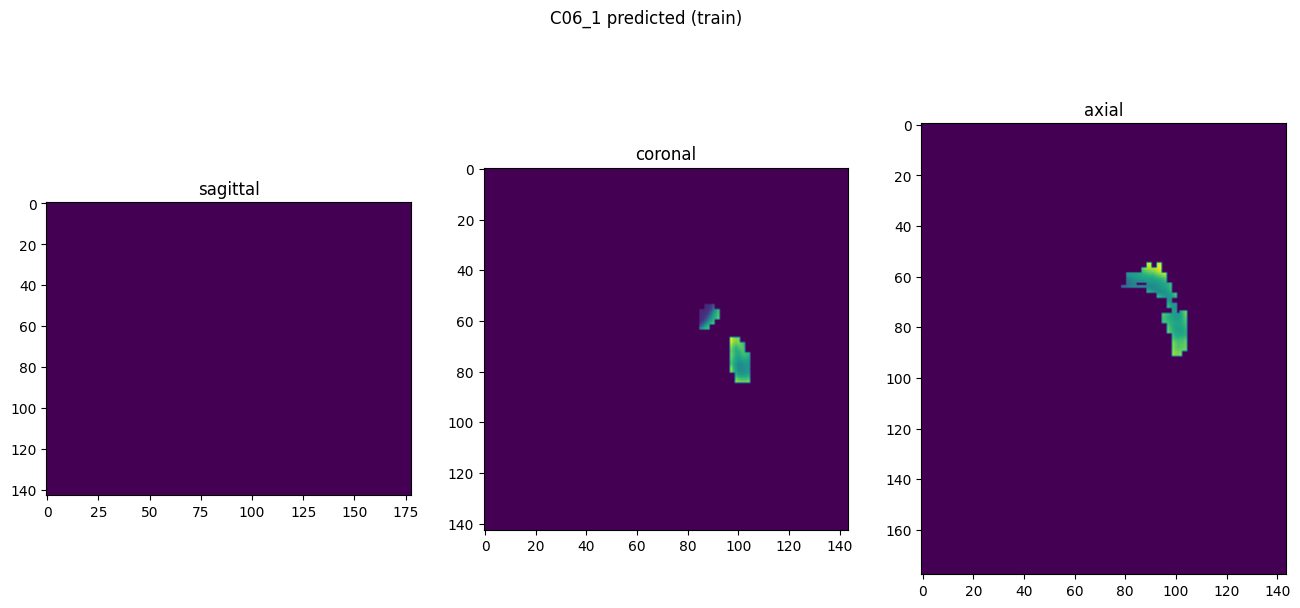

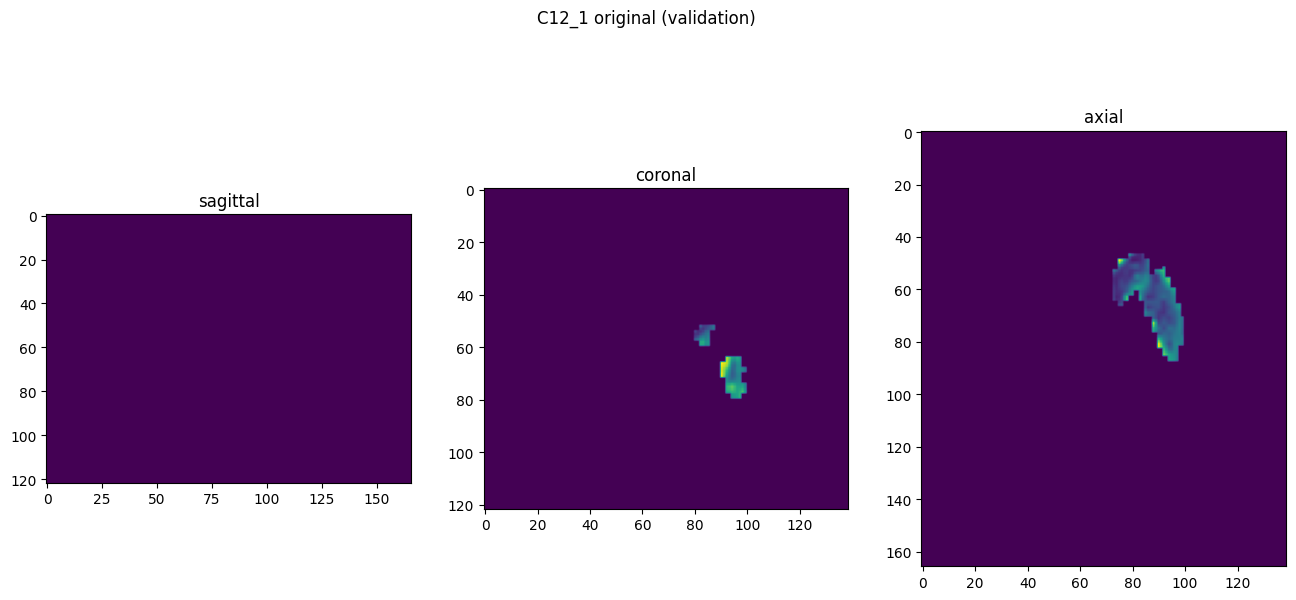

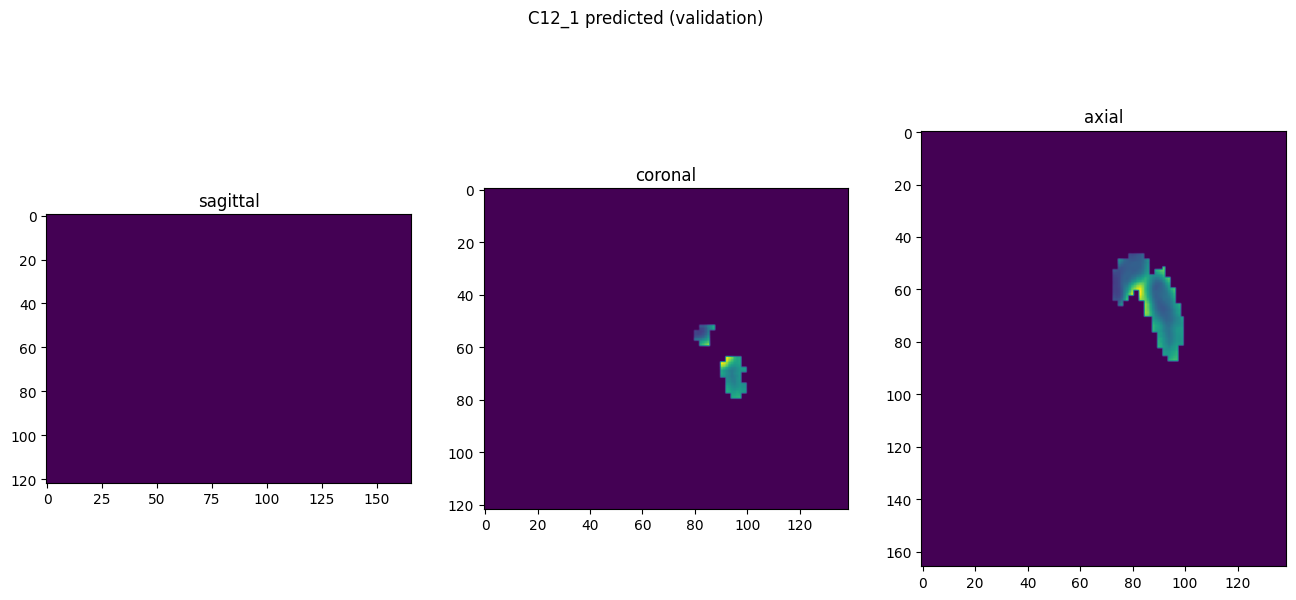

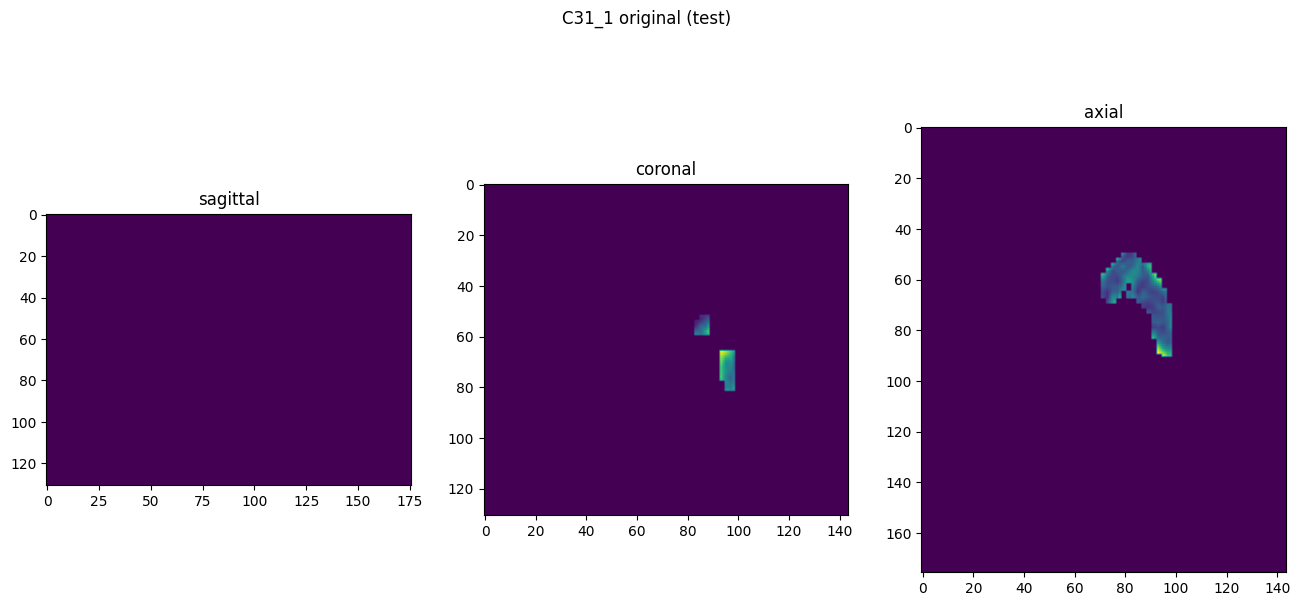

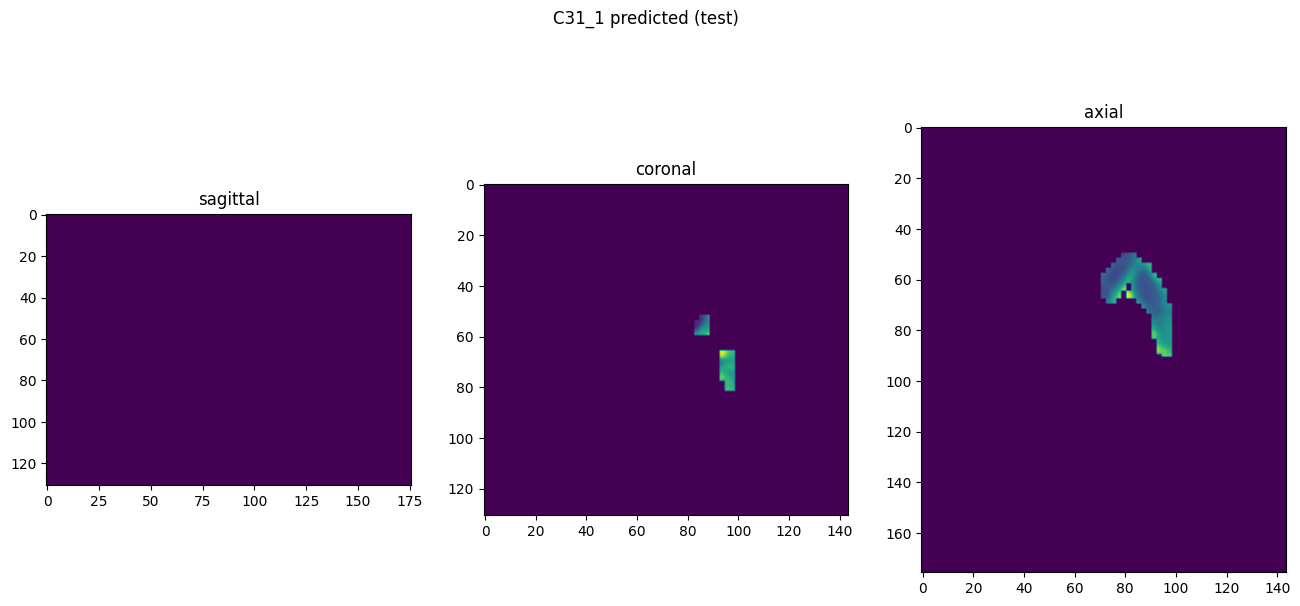

In [10]:
showResults(model, gen, threshold=None, background=False)